In [1]:
import math
import time
import configparser

import numpy as np
import sklearn.linear_model
import sklearn.metrics
from matplotlib import pyplot as plt

from solml import load, cnn
import split
import get_info

%matplotlib inline

Using TensorFlow backend.


In [2]:
config = configparser.ConfigParser()
config.read('../config.ini')
models_filename = config['main']['models']

In [3]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = split.get_sets()

In [4]:
bounding_boxes = get_info.get_bounding_box(train_ids)
cnn_train = cnn.get_cnn_features_list(train_ids, bounding_boxes)
bounding_boxes = get_info.get_bounding_box(val_ids)
cnn_val = cnn.get_cnn_features_list(val_ids, bounding_boxes)
bounding_boxes = get_info.get_bounding_box(test_ids)
cnn_test = cnn.get_cnn_features_list(test_ids, bounding_boxes)

In [5]:
class_weight=None # or 'balanced'

## CNN

In [6]:
n_C = 15
C_list = np.logspace(-10, 3, n_C)
errors = np.zeros(n_C)
for i, C in enumerate(C_list):
    model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C, class_weight=class_weight)
    t = time.time()
    model.fit(cnn_train, train_labels)
    print("LR took %f seconds."%(time.time()-t))
    predictions = model.predict(cnn_val)
    errors[i] = (val_labels!=predictions).sum()/len(val_labels)

LR took 0.679146 seconds.
LR took 0.914404 seconds.
LR took 1.036362 seconds.
LR took 1.586230 seconds.
LR took 2.500262 seconds.
LR took 3.769882 seconds.
LR took 8.144414 seconds.
LR took 16.307713 seconds.
LR took 37.330177 seconds.
LR took 60.086904 seconds.
LR took 63.062312 seconds.
LR took 65.215640 seconds.
LR took 61.077338 seconds.
LR took 62.773758 seconds.
LR took 61.582564 seconds.


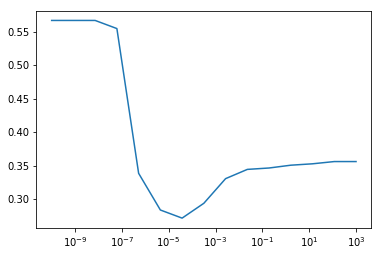

In [7]:
plt.plot(C_list, errors)
plt.xscale('log')

In [8]:
i_opt = np.argmin(errors)
C_opt = C_list[i_opt] #0.000018#
print('optimal C : %f'%C_opt)
model_cnn = sklearn.linear_model.LogisticRegression(penalty='l2', C=C_opt, class_weight=class_weight)
t = time.time()
model_cnn.fit(cnn_train, train_labels)
print("LR took %f seconds."%(time.time()-t))
predictions = model_cnn.predict(cnn_test)
err = (test_labels!=predictions).sum()/len(test_labels)

optimal C : 0.000037
LR took 7.973318 seconds.


In [9]:
err

0.245

In [10]:
cnn_proba_val = model_cnn.predict_proba(cnn_val)[:,:-1]
cnn_proba_test = model_cnn.predict_proba(cnn_test)[:,:-1]

## LR

In [11]:
l = 6
color = False
train_reduc, val_reduc, test_reduc = split.load_images(train_ids, val_ids, test_ids, l, color)
train_reduc = train_reduc.reshape((train_reduc.shape[0], l*l))
val_reduc = val_reduc.reshape((val_reduc.shape[0], l*l))
test_reduc = test_reduc.reshape((test_reduc.shape[0], l*l))

In [12]:
model_lr = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10, class_weight=class_weight)
model_lr.fit(train_reduc, train_labels)
predictions = model_lr.predict(val_reduc)
error = (val_labels!=predictions).sum()/len(val_labels)
error

0.49770546516478931

In [13]:
reduc_proba_val = model_lr.predict_proba(val_reduc)[:,:-1]
reduc_proba_test = model_lr.predict_proba(test_reduc)[:,:-1]

In [14]:
val_mix = np.concatenate([cnn_proba_val, reduc_proba_val], axis=1)
test_mix = np.concatenate([cnn_proba_test, reduc_proba_test], axis=1)

In [15]:
model_ensemble = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10, class_weight=class_weight)
model_ensemble.fit(val_mix, val_labels)
predictions = model_ensemble.predict(test_mix)
error = (test_labels!=predictions).sum()/len(test_labels)
error

0.245

In [16]:
probas = model_ensemble.predict_proba(test_mix)

## Confusion matrix

In [17]:
sklearn.metrics.confusion_matrix(test_labels, predictions)

array([[925,  32,  11,  72],
       [ 46, 416,  15,  54],
       [ 27,  17, 194,  24],
       [163, 106,  21, 277]])

## Confidence

In [18]:
confidence = np.max(probas, axis=1)

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          1.,   4.,   5.,   5.,   6.,   2.,   4.,   6.,   3.,   0.,   8.,
          6.,   6.,  12.,   6.,   8.,  12.,  19.,  17.,  17.,  19.,  15.,
         18.,  17.,  19.,  18.,  18.,  18.,  20.,  12.,  15.,  14.,  17.,
         24.,  29.,  16.,  21.,  18.,  19.,  32.,  19.,  15.,  18.,  19.,
         25.,  22.,  12.,  22.,  24.,  27.,  22.,  27.,  20.,  31.,  31.,
         27.,  22.,  31.,  35.,  35.,  38.,  32.,  28.,  38.,  36.,  40.,
         27.,  38.,  44.,  40.,  48.,  43.,  44.,  52.,  62.,  64.,  61.,
         63.,  74.,  75.,  75.,  76.,  67.,  57.,  36.,  45.,  44.,  24.,
         16.]),
 array([ 0.28020742,  0.28668255,  0.29315769,  0.29963282,  0.30610796,
         0.3125831 ,  0.31905823,  0.32553337,  0.33200851,  0.33848364,
         0.34495878,  0.35143392,  0.35790905,  0.36438419,  0.37085933,
         0.37733446,  0.3838096 ,  0.39028474,  0.39675987,  0.40323501,
         0.40971015,  0.41

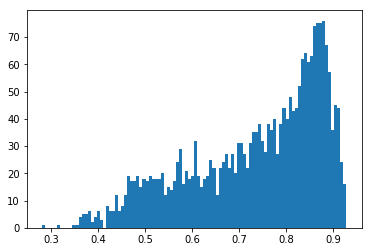

In [19]:
plt.hist(confidence, bins=100)

In [20]:
N = len(confidence)
confidence_order = np.argsort(-confidence)
sorted_error = (predictions[confidence_order]!=test_labels[confidence_order])
nb_errors = np.cumsum(sorted_error)
error_rate = nb_errors/np.arange(N)

/home/salon/.virtualenvs/solar/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


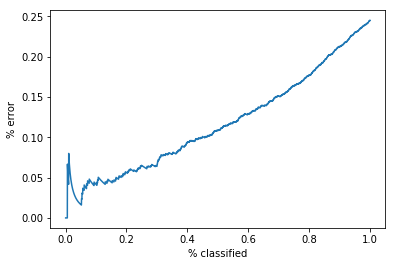

In [21]:
plt.plot(np.arange(N)/N, error_rate)
plt.xlabel('% classified')
plt.ylabel('% error')

In [22]:
def custom_convolution(a, kernel):
    n = len(a)
    k = int((len(kernel)-1)/2)
    
    conv = np.zeros(n)
    for i in range(n):
        imin_kernel = max(0, k-i)
        imax_kernel = min(2*k+1, k+n-i)
        imin_a = max(0, i-k)
        imax_a = min(n, k+1+i)
        conv[i] = (a[imin_a:imax_a]*kernel[imin_kernel:imax_kernel]).sum() / (kernel[imin_kernel:imax_kernel].sum())
    
    return conv

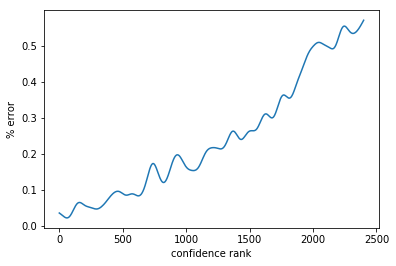

In [23]:
sigma = 40.
kernel_size = int(math.floor(3.5*sigma))
kernel = np.exp(-np.power(np.arange(2*kernel_size+1)-kernel_size, 2.)/(2*np.power(sigma, 2.)))
kernel /= kernel.sum()

smooth_error = custom_convolution(sorted_error, kernel)
plt.figure()
plt.plot(smooth_error)
plt.xlabel('confidence rank')
plt.ylabel('% error')

## Save model

In [24]:
import pickle
pickle.dump((model_cnn, model_lr, model_ensemble), open(models_filename, 'wb'))